In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"   #(xxxx is your specific GPU ID)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import math
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [4]:
print(torch.__version__)

1.10.1+cu102


In [5]:
# comparing to vit, here I changed kernel size, stride size and the size of fc1_1, due to the different outputsize of pre-train

In [6]:
###################### model 2 (keyword)###################### 

class keyword_net(nn.Module):
    def __init__(self):
        super(keyword_net, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)            
        self.cvd = nn.Conv2d(in_channels=7, out_channels=3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)) 
        self.fc1_1 = nn.Linear(71910,128) 
        self.fc1_2 = nn.Linear(128,256) 
        self.keyword_output_1 = nn.Linear(256,11) 
        self.fc2_1 = nn.Linear(71910,512) # Dense_2_1 = tf.keras.layers.Dense(shape_2_1, activation=actv_fun_2_1,name='fc2_1')
        self.fc2_2 = nn.Linear(512,512) # tf.keras.layers.Dense(shape_2_2, activation=actv_fun_2_2,name='fc2_2')
        self.getalphafromy2 = nn.Linear(512,512)
        self.fc2_3 = nn.Linear(1024,512)
        self.keyword_output_2 = nn.Linear(512,23) # tf.keras.layers.Dense(10, activation='softmax',name='command_output')


    def forward(self, x):
   
        # convert 512*7*7 to 512*49
#         print("before:" , x.shape)
        x =  x.reshape(x.size(0), x.size(1), x.size(2), -1)
#         print("after:" , x.shape)
        x = self.cvd(x)
        x = x.view(x.size(0), -1) 
        
        y1 = self.fc1_1(x)
        y1 = self.relu(y1)
        y1 = self.fc1_2(y1)
        y1 = self.sigmoid(y1) 
        y1 = self.keyword_output_1(y1)
        y1 = self.softmax(y1)
        
        y2 = self.fc2_1(x)
        y2 = self.relu(y2)
        y2 = self.fc2_2(y2)
        y2 = self.sigmoid(y2) 
        y2 = self.keyword_output_2(y2)
        y2 = self.softmax(y2)
        
        return y1,y2

In [7]:
class CombinedModel(nn.Module):
    def __init__(self, PRETRAIN_MODEL,keyword_net):
        super(CombinedModel, self).__init__()
        self.pretrain_model = PRETRAIN_MODEL
        self.keyword_net = keyword_net
        
    def forward(self, x):
#         print(x.shape)
#         print(x[:][0].shape)
        x1 = self.pretrain_model(x[:,0,:,:])
        x1 = torch.unsqueeze(x1, dim=1)
#         print(x1.shape)
        x2 = self.pretrain_model(x[:,1,:,:])
        x2 = torch.unsqueeze(x2, dim=1)
        x3 = self.pretrain_model(x[:,2,:,:])
        x3 = torch.unsqueeze(x3, dim=1)
        x4 = self.pretrain_model(x[:,3,:,:])
        x4 = torch.unsqueeze(x4, dim=1)        
        x5 = self.pretrain_model(x[:,4,:,:])
        x5 = torch.unsqueeze(x5, dim=1)        
        x6 = self.pretrain_model(x[:,5,:,:])
        x6 = torch.unsqueeze(x6, dim=1)        
        x7 = self.pretrain_model(x[:,6,:,:]) 
        x7 = torch.unsqueeze(x7, dim=1)      
                
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7), axis=1)
#         print(x.shape)
        y1,y2= self.keyword_net(x)
        return y1,y2
        

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
train_number = 11
train_image = 30 #10:20%, 20: 40%, 30:60%
val_image = 10
test_image = 10
# load_Data = ImageDataGenerator(preprocessing_function=preprocess_input)
load_Data = ImageDataGenerator(rescale=1./255)
Train_X = []
Train_Y_command = []
Train_Y_subject = []
Val_X = []
Val_Y_command = []
Val_Y_subject = []
Test_X = []
Test_Y_command = []
Test_Y_subject = []

for chan in range(1,8):
    chanl = str(chan)
    train_generator = load_Data.flow_from_directory("sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Train"%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = train_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    All_command_class = tf.keras.utils.to_categorical(train_generator.classes, num_classes=23)
    All_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    All_Inputs = [next(train_generator)[0][0] for _ in range(len(train_generator))]
    All_Inputs = np.array(All_Inputs)
    # count the training data number to select the training size
    count = []
    c = 0
    word = train_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and train_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = train_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)

    select_indexs_train = np.array(count) <= train_image
    train_participant_no =  participant_no[select_indexs_train]  
    Train_Inputs = All_Inputs[select_indexs_train]
    Train_command_class = All_command_class[select_indexs_train]
    Train_participant_class = All_participant_class[select_indexs_train]


    val_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Val'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                   shuffle=False)
    Val_command_class = tf.keras.utils.to_categorical( val_generator.classes, num_classes=23)
    image_names = val_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Val_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Val_Inputs = [next(val_generator)[0][0] for _ in range(len(val_generator))]
    Val_Inputs = np.array(Val_Inputs)
    count = []
    c = 0
    word = val_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and val_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = val_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_val = np.array(count) <= val_image
    val_participant_no =  participant_no[select_indexs_val]  
    Val_Inputs = Val_Inputs[select_indexs_val]
    Val_command_class = Val_command_class[select_indexs_val]
    Val_participant_class = Val_participant_class[select_indexs_val]

    test_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Test'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = test_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Test_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Test_command_class = tf.keras.utils.to_categorical(test_generator.classes, num_classes=23)
    Test_Inputs = [next(test_generator)[0][0] for _ in range(len(test_generator))]
    Test_Inputs = np.array(Test_Inputs)

    count = []
    c = 0
    word = test_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and test_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = test_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_test = np.array(count) <= test_image
    test_participant_no =  participant_no[select_indexs_test]  
    Test_Inputs = Test_Inputs[select_indexs_test]
    Test_command_class = Test_command_class[select_indexs_test]
    Test_participant_class = Test_participant_class[select_indexs_test]

    Train_X.append(Train_Inputs.transpose(0,3,1,2))
    Val_X.append(Val_Inputs.transpose(0,3,1,2))
    Test_X.append(Test_Inputs.transpose(0,3,1,2))
    
    
Train_Y_command = Train_command_class
Train_Y_subject = Train_participant_class
Val_Y_command = Val_command_class
Val_Y_subject = Val_participant_class
Test_Y_command = Test_command_class
Test_Y_subject = Test_participant_class

Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.


In [11]:
del val_generator,train_generator,test_generator

In [12]:
Train_X[0].shape,Val_X[0].shape,Test_X[0].shape

((7590, 3, 224, 224), (2530, 3, 224, 224), (2530, 3, 224, 224))

In [13]:
Train_Inputs = torch.from_numpy(np.array(Train_X))
Val_Inputs = torch.from_numpy(np.array(Val_X))
Test_Inputs = torch.from_numpy(np.array(Test_X))

In [14]:
Train_Inputs[0][0].shape

torch.Size([3, 224, 224])

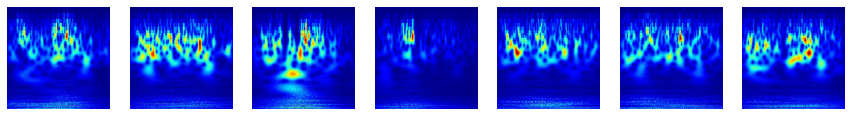

In [15]:
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(Train_Inputs[i][0].permute(1, 2, 0))
    plt.axis("off")
plt.show()
plt.close()

In [ ]:
y_test_sub = torch.from_numpy(Test_participant_class).to(device)
y_test_comd = torch.from_numpy(Test_command_class).to(device)

In [17]:
batch = 32
dataset = TensorDataset(Train_Inputs.permute(1,0,2,3,4), torch.from_numpy(Train_participant_class), torch.from_numpy(Train_command_class))
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

val_dataset = TensorDataset(Val_Inputs.permute(1,0,2,3,4), torch.from_numpy(Val_participant_class), torch.from_numpy(Val_command_class))
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

weight_a : 2.000000
1 run: 
-------------------------------
Epoch 1 :
loss: 6.047003269195557 , subject train accuracy: 0.8367909663865546 , command train accuracy: 0.14495798319327732 , val subject accuracy: 0.9853754940711462 , val command accuracy: 0.27391304347826084
Epoch 2 :
loss: 5.850173473358154 , subject train accuracy: 0.9975052521008403 , command train accuracy: 0.3314075630252101 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.3782608695652174
Epoch 3 :
loss: 5.885787487030029 , subject train accuracy: 0.9996060924369747 , command train accuracy: 0.4338235294117647 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.4758893280632411
Epoch 4 :
loss: 5.5105767250061035 , subject train accuracy: 0.9997373949579832 , command train accuracy: 0.5728291318196208 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.6320158102766799
Epoch 5 :
loss: 6.043718338012695 , subject train accuracy: 0.9997373949579832 , command train ac

loss: 5.293693542480469 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9798418972332016
Epoch 45 :
loss: 5.293679714202881 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9798418972332016
Epoch 46 :
loss: 5.293679237365723 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9798418972332016
Epoch 47 :
loss: 5.293673038482666 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9798418972332016
Epoch 48 :
loss: 5.293667793273926 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9802371541501976
Epoch 49 :
loss: 5.293668270111084 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject ac

loss: 5.294487953186035 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9774703557312253
Epoch 24 :
loss: 5.294318199157715 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9774703557312253
Epoch 25 :
loss: 5.294179916381836 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9774703557312253
Epoch 26 :
loss: 5.294156074523926 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9766798418972332
Run:  2 , and its best  1.9786561264822136

Run  2 Subject Accuracy 1.0 command Accuracy is : 0.98300395256917 Sub_1: 0.9739130434782609 Sub_2: 0.9782608695652174 Sub_3: 0.9956521739130435 Sub_4: 0.9869565217391304 Sub_5: 0.9956521

loss: 5.672337532043457 , subject train accuracy: 1.0 , command train accuracy: 0.6099439776745164 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.6106719367588933
Epoch 5 :
loss: 5.811097145080566 , subject train accuracy: 1.0 , command train accuracy: 0.6919642857142857 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7015810276679841
Epoch 6 :
loss: 5.632297992706299 , subject train accuracy: 1.0 , command train accuracy: 0.7323179272543482 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7130434782608696
Epoch 7 :
loss: 5.313604354858398 , subject train accuracy: 1.0 , command train accuracy: 0.7408088235294118 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.733596837944664
Epoch 8 :
loss: 5.641544342041016 , subject train accuracy: 1.0 , command train accuracy: 0.8188462885988861 , val subject accuracy: 1.0 , val command accuracy: 0.8241106719367589
Epoch 9 :
loss: 5.304858207702637 , subject train ac

loss: 5.296582221984863 , subject train accuracy: 1.0 , command train accuracy: 0.9996060924369747 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9735177865612649
Epoch 16 :
loss: 5.305390357971191 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9766798418972332
Epoch 17 :
loss: 5.295318603515625 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9778656126482214
Epoch 18 :
loss: 5.295018672943115 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9782608695652174
Epoch 19 :
loss: 5.295002460479736 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9786561264822135
Epoch 20 :
loss: 5.294950008392334 ,

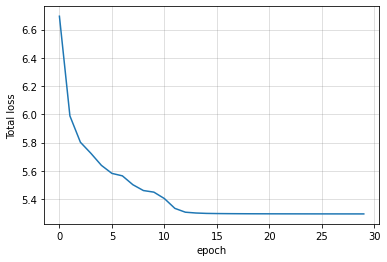

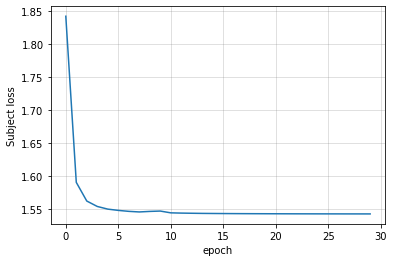

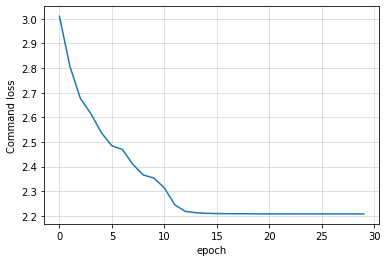

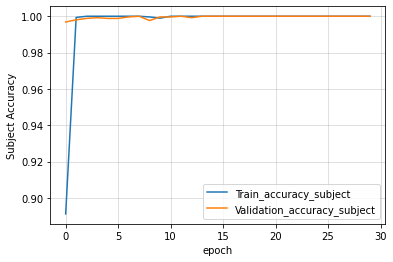

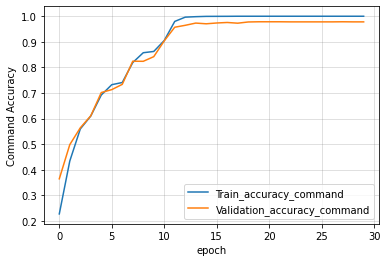

In [18]:
unfreeze_bool = True
# Perfomance = pd.DataFrame()
Perfomance = pd.read_csv('Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_30Image_weight_a_0420.csv')

for weight_a in [2.0]: #[0.25,0.5,0.75,1,1.25,1.5,1.75]
    MODEL_LIST = []
    LOSS_LIST = []
    best_in_total = 0
    print('weight_a : %f'%(weight_a))

    for run in range(0,5):
        print(f"{run + 1} run: \n-------------------------------") 
        resnet = models.resnet18(pretrained=True)
        PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2])) 
        model = CombinedModel(PRETRAIN_MODEL,keyword_net())

        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        model.to(device)
        Train_accuracy_sub = []
        Train_accuracy_comd = []
        Val_accuracy_sub = [] 
        Val_accuracy_comd = [] 
        losses_sub = []
        losses_com = [] 
        total_losses = []
        best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
        best_in_run = 0
        patience = 0
        start = timeit.default_timer()
        for epoch in range(100):
            print(f"Epoch {epoch + 1} :")
            for param in model.pretrain_model.parameters():
                param.requires_grad = unfreeze_bool
            for param in model.keyword_net.parameters():
                param.requires_grad = True
            t_acc_comd = []   
            t_acc_sub = []   
    #         for name, param in model.named_parameters():
    #             if param.requires_grad:
    #                 print(f"{name} is trainable")
    #             else:
    #                 print(f"{name} is frozen")
            losses_sub_batch=[]
            losses_com_batch=[]
            total_loss_batch=[]
            for id_batch, (x_batch,y_batch_sub, y_batch_comd) in enumerate(dataloader):
                x_batch = x_batch.to(device)
                y_batch_sub = y_batch_sub.to(device)
                y_batch_comd = y_batch_comd.to(device)
                pred_y = model(x_batch)
                loss_sub = loss_function(pred_y[0], y_batch_sub)
                loss_mov = loss_function(pred_y[1], y_batch_comd)
                loss = weight_a*loss_sub + loss_mov
                model.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss_batch.append(loss.item())
                losses_sub_batch.append(loss_sub.item())
                losses_com_batch.append(loss_mov.item())
                t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
                t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
            losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
            losses_com.append(sum(losses_com_batch)/len(losses_com_batch))
            total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
            Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
            Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
            for param in model.parameters():
                param.requires_grad = False
            model.eval()
            v_sub_pred = []
            v_comd_pred = [] 
            v_sub_real = []
            v_comd_real = []
            for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
                x_batch = x_batch.to(device)
                y_batch_sub = y_batch_sub.to(device)
                y_batch_comd = y_batch_comd.to(device)
                pred_y = model(x_batch)
                v_sub_real.append( torch.argmax (y_batch_sub, 1))
                v_comd_real.append( torch.argmax (y_batch_comd, 1))
                v_sub_pred.append(torch.argmax(pred_y[0], 1) )
                v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

            v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
            v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
            v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
            v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
            Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
            Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
            print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
                  ", command train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
                  ", val command accuracy:",Val_accuracy_comd[-1])
            if Val_accuracy_sub[-1] + Val_accuracy_comd[-1] > best_in_run:
                best_in_run = Val_accuracy_sub[-1] + Val_accuracy_comd[-1]
                patience = 0
                best_state_dict_in_run = copy.deepcopy(model.state_dict())
                if best_in_run > best_in_total: 
                    best_in_total = best_in_run
                    best_state_dict_in_total = copy.deepcopy(model.state_dict())
            else:
                patience = patience + 1
            if patience>=10:
                print("Run: ", run+1, ", and its best ",best_in_run)
                break    
        stop = timeit.default_timer()
        run_time = stop - start
        del model
        torch.cuda.empty_cache()
        # testing phase
        best_model.load_state_dict(best_state_dict_in_run)
        MODEL_LIST.append( best_state_dict_in_run)
        LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'comd': losses_com,
                          'train_acc_sub' : Train_accuracy_sub,'train_acc_comd' : Train_accuracy_comd,
                         'val_acc_sub' : Val_accuracy_sub,'val_acc_comd' : Val_accuracy_comd,})
        for param in best_model.parameters():
            param.requires_grad = False
        pred_y_sub = []
        pred_y_comd = []
        best_model.to(device)
        best_model.eval() 
        for i in range(Test_Inputs.shape[1]):
            pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
            pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
        sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
        comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))

        acc_on_subjects=[]
        for s in range(1,12):
            tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
            x_test = tensordata.to(device)
            y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
            pred_y_comd = []
            for i in range(len(x_test)):
                pred_y_comd.append(best_model(x_test[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
            comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))        
            acc_on_subjects.append(comd_acc_s.item()) 

        Perfomance = Perfomance.append({'weight_a':weight_a,'Run': run+1,'Training Time':run_time,'Subject Accuracy':sub_acc.item(),'Command Accuracy':comd_acc.item(),
                                       'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                        'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                        'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                        'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10]}, ignore_index=True)
        print('\nRun ', run+1,'Subject Accuracy',sub_acc.item(),'command Accuracy is :',comd_acc.item(),'Sub_1:',acc_on_subjects[0],'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                        'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                        'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                        'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10])

        # # Load the state dictionary into the new model
    #     del best_model
        torch.cuda.empty_cache()

    best_index = (Perfomance.loc[Perfomance['weight_a']==weight_a,'Command Accuracy'] + Perfomance.loc[Perfomance['weight_a']==weight_a,'Subject Accuracy']).idxmax()
    best_index = Perfomance.loc[best_index,'Run'].item() - 1
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    best_model.load_state_dict(MODEL_LIST[int(best_index)])
    best_loss_record = LOSS_LIST[int(best_index)]

    Perfomance.to_csv("Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_30Image_weight_a_0420.csv",index=False)

    plt.plot(best_loss_record['total'])
    plt.ylabel('Total loss')
    plt.xlabel('epoch')
    plt.grid(color='gray', alpha=0.3)
    plt.show()

    plt.plot(best_loss_record['sub'])
    plt.ylabel('Subject loss')
    plt.xlabel('epoch')
    plt.grid(color='gray', alpha=0.3)
    plt.show()

    plt.plot(best_loss_record['comd'])
    plt.ylabel('Command loss')
    plt.grid(color='gray', alpha=0.3)
    plt.xlabel('epoch')
    plt.show()


    plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
    plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
    plt.ylabel('Subject Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(color='gray', alpha=0.3)
    plt.show()

    plt.plot(best_loss_record['train_acc_comd'],label="Train_accuracy_command")
    plt.plot(best_loss_record['val_acc_comd'],label="Validation_accuracy_command")
    plt.ylabel('Command Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(color='gray', alpha=0.3)
    plt.show()


In [19]:
Perfomance

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time,weight_a
0,0.981423,1.0,0.982609,0.965217,0.930435,0.982609,0.986957,0.986957,0.995652,0.986957,0.986957,0.995652,0.995652,0.999605,3980.561102,0.25
1,0.981028,2.0,0.991304,0.952174,0.960870,0.978261,0.986957,0.973913,0.991304,0.982609,0.991304,0.995652,0.986957,0.999605,1923.483094,0.25
2,0.981028,3.0,0.995652,0.947826,0.960870,0.965217,0.982609,0.982609,0.991304,0.986957,0.991304,0.995652,0.991304,0.999209,2512.334132,0.25
3,0.982609,4.0,0.986957,0.973913,0.960870,0.965217,0.991304,0.982609,1.000000,0.982609,0.986957,0.986957,0.991304,0.999605,2146.133264,0.25
4,0.979051,5.0,0.978261,0.952174,0.943478,0.978261,0.991304,0.986957,0.986957,0.982609,0.995652,0.986957,0.986957,0.998814,3200.610714,0.25
5,0.984190,1.0,0.986957,0.956522,0.960870,0.973913,0.995652,0.982609,0.995652,0.986957,1.000000,0.995652,0.991304,1.000000,2360.909360,0.50
6,0.984980,2.0,0.991304,0.965217,0.956522,0.982609,0.991304,0.982609,0.995652,0.986957,0.995652,0.991304,0.995652,0.999605,3153.441482,0.50
7,0.984980,3.0,0.986957,0.978261,0.952174,0.965217,0.991304,0.982609,1.000000,0.991304,0.995652,0.995652,0.995652,1.000000,1789.741440,0.50
8,0.983399,4.0,0.991304,0.956522,0.947826,0.978261,0.991304,0.978261,1.000000,0.991304,1.000000,0.995652,0.986957,0.999209,3272.531790,0.50
9,0.983399,5.0,0.982609,0.969565,0.956522,0.978261,0.991304,0.991304,1.000000,0.978261,0.995652,0.986957,0.986957,0.999605,2365.734377,0.50
